<a href="https://colab.research.google.com/github/vitorfrois/PageRank/blob/main/PageRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Page Rank

In [ ]:
import numpy as np
import networkx as nx

The PageRank algorithm is one way of ranking the nodes in a graph by importance.

Consider a tiny network. Nodes are pages and arcs are hyperlinks. 

If users start on random pages and randomly click in hyperlinks, after a certain amount of time, what page would be the most visited one?

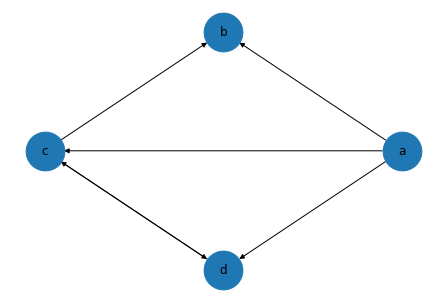

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(['a','b','c','d'])
G.add_edges_from([('a','b'),('a','c'),('a','d'),('c','b'),('c','d'),('d','c')])
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, label="Tiny-Web")

It is possible to express this graph as an adjacency matrix Α, which is easier to analyze.

In [ ]:
AdjM = nx.to_numpy_array(G).T
AdjM

array([[0., 0., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 1., 0.]])

As the above graph shows, node B has no outgoing link. This would cause the surfer to stop. 


We can add virtual links from B to each node in the graph (random jumps) to prevent this.

In [ ]:
for col in AdjM.T:
  if(np.sum(col) == 0):
    col += 1
AdjM

array([[0., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.]])

The damping factor, represented by ϵ $[0,1]$ is the probability that a user follows one link and $1-ϵ$ that he do a random jump.

$n$ is the number of nodes in the web.

In [ ]:
damp  = 0.85
n = len(AdjM[0])
print(damp, n)

0.85 4


Now we must represent a probability matrix Â. All the links have equal weights, so the probability of going to each neighbor of some node is $\frac{1}{N}$ where $N$ is the number of neighbors.

In [ ]:
probM = np.zeros_like(AdjM)
for i in range(0, n):
  sum = np.sum(AdjM.T[i])
  probM.T[i] = AdjM.T[i] * (1/sum)
probM

array([[0.        , 0.25      , 0.        , 0.        ],
       [0.33333333, 0.25      , 0.5       , 0.        ],
       [0.33333333, 0.25      , 0.        , 1.        ],
       [0.33333333, 0.25      , 0.5       , 0.        ]])

We also must have a ones matrix $11$, that represents random jumps probability. The probability to go to any other node through a random jump is the same for all nodes.

In [ ]:
ones = np.ones_like(probM)
ones /= n
ones

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

Calculate $A=ϵÂ+\frac{1-ϵ}{n}11^T$

In [ ]:
A = damp*probM + (1-damp) * ones
A

array([[0.0375    , 0.25      , 0.0375    , 0.0375    ],
       [0.32083333, 0.25      , 0.4625    , 0.0375    ],
       [0.32083333, 0.25      , 0.0375    , 0.8875    ],
       [0.32083333, 0.25      , 0.4625    , 0.0375    ]])

Now, the $x$ PageRank is the eigenvector of $A$ corresponding to the eigenvalue $λ = 1$

In [ ]:
eig, prresult = np.linalg.eig(A)
x = prresult.T[0]
x

array([0.17900289, 0.51248774, 0.66533496, 0.51248774])

Now we just have to normalize the values, so the sum of them all $= 1$.

In [ ]:
x /= np.sum(x)
x

array([0.09575864, 0.27415829, 0.35592479, 0.27415829])

With the PageRank vector in mind, we can assume based on Graph G that the importance order is $c>b=d>a$.

When checking with NetworkX library, we see our results are correct.

In [ ]:
nx.pagerank(G)

{'a': 0.09575851632006248,
 'b': 0.2741586154363689,
 'c': 0.3559242528071995,
 'd': 0.2741586154363689}

#Iterative Method
Solving the system of linear equations for finding eigenvalues/eigenvectors is possible for small networks, but they are not efficient strategies for very large systems.

The iterative method (Power Method) consists in guessing an initial PageRank vector $x_0$ and computing $x_{t+1}$ until $$\|x_t - x_{t-1}\|$$ is sufficiently small (the series converged). We use the following formulas:
$$x_{t+1}=(ϵA+(1-ϵ)\frac{1}{N}11^T)x_t$$
$$x_{t+1} = x_{t+1}/\|x_{t+1}\|_2$$


In [ ]:

xo

array([[0.51445339],
       [0.19116909],
       [0.06352979],
       [0.23084773]])

In [ ]:
def diffNorm(x1, x2):
  return np.linalg.norm(x2-x1,2)

In [ ]:
def f1(x1, x2):
  x1 = x2 @ x1 
  return x1

In [ ]:
def f2(x2):
  return x2/np.linalg.norm(x2)

In [ ]:
def iterative_pr(adj_m):
  N = len(adj_m[0])
  xo = np.random.rand(N,1)
  xo /= np.sum(xo)
  rj_m = np.ones_like(adj_m)/N
  M = ((damp*adj_m) + ((1-damp)*rj_m))
  while(True):
    xt = f1(xo, M)
    # xt = f2(xt)
    if(diffNorm(xt,xo) < 0.00000001):
      break
    xo = xt
  return xo/np.sum(xo)

In [ ]:
print(iterative_pr(AdjM))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in matmul
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


LinAlgError: ignored

In [ ]:
nx.pagerank(G)

{'a': 0.09575851632006248,
 'b': 0.2741586154363689,
 'c': 0.3559242528071995,
 'd': 0.2741586154363689}